In [1]:
using Plots, LinearAlgebra, HDF5, Random, FastGaussQuadrature, LaTeXStrings, Statistics

In [2]:
pyplot()
Plots.PyPlotBackend()

Plots.PyPlotBackend()

In [3]:
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/splines.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/poisson_solver_splines.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/bump_on_tail_distributions.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/sampling.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/time_marching.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/h5routines.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/visualisation.jl");

In [4]:
fpath = "runs/BoT_Np5e4_k_010_050_np_10_T25.h5"

μₛₐₘₚ = h5read(fpath, "parameters/mu_samp")
μₜᵣₐᵢₙ = h5read(fpath, "parameters/mu_train")

IP = IntegratorParameters(h5read(fpath, "parameters/dt"),
                          h5read(fpath, "parameters/n_t"), 
                          h5read(fpath, "parameters/n_s"),
                          h5read(fpath, "parameters/n_p"),
                          h5read(fpath, "parameters/n_h"),
                          h5read(fpath, "parameters/N_p")
                            )

S = PBSpline(h5read(fpath, "parameters/p"), IP.nₕ, 2.0*pi/μₛₐₘₚ[1])

X = h5read(fpath, "snapshots/X");
V = h5read(fpath, "snapshots/V");
E = h5read(fpath, "snapshots/E");
# D = h5read(fpath, "snapshots/D");
# Φ = h5read(fpath, "snapshots/Phi");

In [5]:
# Reference draw
P₀ = Particles(X[:,1], V[:,1], ones(IP.Nₚ) .* S.L ./ IP.Nₚ);

In [6]:
μₛₐₘₚ' 

1×5 Adjoint{Float64,Array{Float64,1}}:
 0.3  0.03  0.1  4.5  0.5

In [7]:
μₜᵣₐᵢₙ

10×5 Array{Float64,2}:
 0.1       0.03  0.1  4.5  0.5
 0.144444  0.03  0.1  4.5  0.5
 0.188889  0.03  0.1  4.5  0.5
 0.233333  0.03  0.1  4.5  0.5
 0.277778  0.03  0.1  4.5  0.5
 0.322222  0.03  0.1  4.5  0.5
 0.366667  0.03  0.1  4.5  0.5
 0.411111  0.03  0.1  4.5  0.5
 0.455556  0.03  0.1  4.5  0.5
 0.5       0.03  0.1  4.5  0.5

# EVD

In [8]:
# XV = hcat(X, V);
XV = copy(X)
for p in 1:IP.nₚ
    # XV = hcat(XV, V[:,1+(p-1)*IP.nₛ])
    XV = hcat(XV, V[:,1+(p-1)*IP.nₛ]) #, E[:,p*IP.nₛ])
    #print(1+(p-1)*IP.nₛ, " ", p*IP.nₛ, "\n" )
end

# clear 
X, V = 0, 0;

In [9]:
size(XV)

(50000, 2520)

In [10]:
function sorteigen(evals::Vector{T},evecs::Matrix{T}) where {T<:Real}
    p = sortperm(abs.(evals), lt=isless, rev=true)
    return evals[p], evecs[:, p]
end

sorteigen (generic function with 1 method)

In [11]:
# @time F = eigen(Xₑₓₜ' * Xₑₓₜ);
# Λ, Ω = sorteigen(F.values, F.vectors);
@time F = eigen(XV' * XV);
Λ, Ω = sorteigen(F.values, F.vectors);
@time Fₑ = eigen(E' * E);
Λₑ, Ωₑ = sorteigen(Fₑ.values, Fₑ.vectors);

 16.171898 seconds (4.61 M allocations: 416.125 MiB, 0.08% gc time)
 15.042327 seconds (27 allocations: 193.165 MiB)


In [12]:
# clear
F, Fₑ = 0, 0
GC.gc()

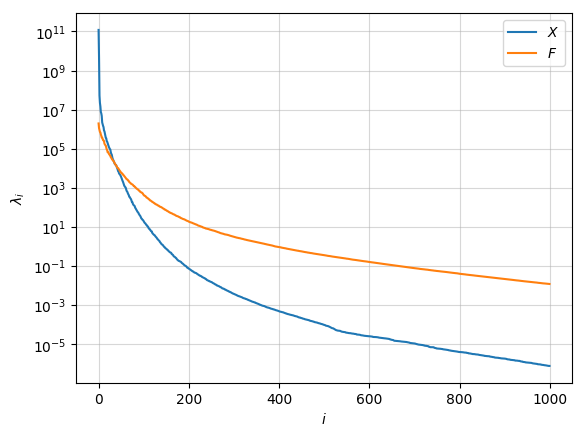

PyObject <matplotlib.legend.Legend object at 0x7f3599bfd780>

In [13]:
PyPlot.plot(abs.(Λ)[1:1000])
PyPlot.plot(abs.(Λₑ)[1:1000])
PyPlot.xlabel(L"$i$")
PyPlot.ylabel(L"$\lambda_i$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
PyPlot.legend([L"$X$", L"$F$"])
#PyPlot.savefig("../Presentations/SPROM Workshop/SVDs_BoT.pdf")

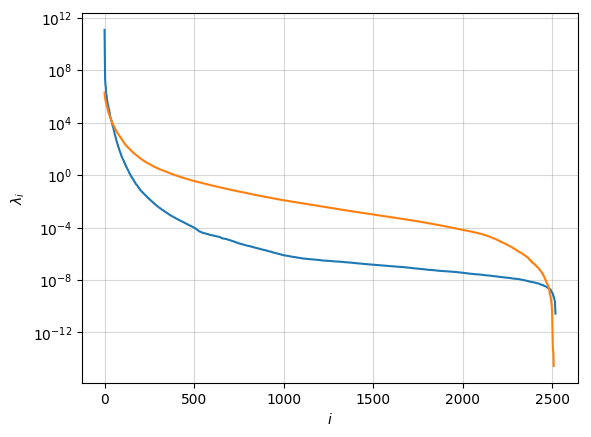

In [14]:
PyPlot.plot(abs.(Λ))
PyPlot.plot(abs.(Λₑ))
PyPlot.xlabel(L"$i$")
PyPlot.ylabel(L"$\lambda_i$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
#PyPlot.legend([L"$X_v$", L"$E$"])

# Projection Matrices

In [15]:
function get_Ψ(S, Λ, Ω, tol, k=0)
    E = sum(Λ)
    Eᵣ = 0
    if k == 0
        k = 1
        while 1 - (Eᵣ + Λ[k])/E > tol
            Eᵣ += Λ[k]
            k+=1
        end
    end
    Ψ = S*Ω[:,1:k]
    for i in 1:k
        Ψ[:,i] ./= sqrt(abs.(Λ[i]))
    end
return k, Ψ
end

k, Ψ = get_Ψ(XV, Λ, Ω, 1e-9, 0)
k

114

In [16]:
kₑ, Ψₑ = get_Ψ(E, Λₑ, Ωₑ, 1e-5, 0)
kₑ

409

In [38]:
# # clear 
XV, E = 0, 0
Λ, Λₑ, Ω, Ωₑ = 0, 0, 0, 0
GC.gc()

# DEIM

In [17]:
function deim_get_Π(Ψ)
    N, k = size(Ψ)
    j = argmax(Ψ[:,1])
    Π = zeros(N, k)
    Π[j,1] = 1.0
    r = zeros(N)

    for i in 2:k
        c = (Π[:,1:(i-1)]' * Ψ[:,1:(i-1)]) \ (Π[:,1:(i-1)]' * Ψ[:,i])
        r .= Ψ[:,i] - Ψ[:,1:(i-1)] * c
        j = argmax(r)

        Π[j,i] = 1.0
    end
    return Π
end

deim_get_Π (generic function with 1 method)

In [18]:
@time Πₑ = deim_get_Π(Ψₑ);

195.819607 seconds (3.57 M allocations: 125.599 GiB, 4.73% gc time)


In [20]:
h5open("runs/BoT_Np5e4_k_010_050_np_10_T25_projections.h5", "w") do file
    g = g_create(file, "parameters") # create a group
    g["N_p"] = IP.Nₚ
    g["n_h"] = S.nₕ
    g["p"] = S.p
    g["dt"] = IP.dt
    g["n_t"] = IP.nₜ
    g["n_s"] = IP.nₛ
    g["n_p"] = IP.nₚ
    g["mu_samp"] = μₛₐₘₚ             
    g["mu_train"] = μₜᵣₐᵢₙ
    
    g["k"] = k
    g["k_e"] = kₑ
         
    f = g_create(file, "projections")
    f["Psi"] = Ψ
    f["Psi_e"] = Ψₑ
    f["Pi_e"] = Πₑ
    
    h = g_create(file, "initial_condition")
    h["x_0"] = P₀.x
    h["v_0"] = P₀.v
    h["w"] = P₀.w
end;